In [2]:
import gpxpy
import gpxpy.gpx

In [82]:
import gpxpy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks
from geopy.distance import geodesic
import numpy as np

# Parse the GPX file
gpx_file = open('hr100.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

parsed_gpx = []
total_distance = 0

for track in gpx.tracks:
    for segment in track.segments:
        for i in range(1, len(segment.points)):
            point1 = segment.points[i - 1]
            point2 = segment.points[i]
            distance = geodesic((point1.latitude, point1.longitude), (point2.latitude, point2.longitude)).meters
            total_distance += distance
            parsed_gpx.append({"distance": total_distance, "elevation": point2.elevation})


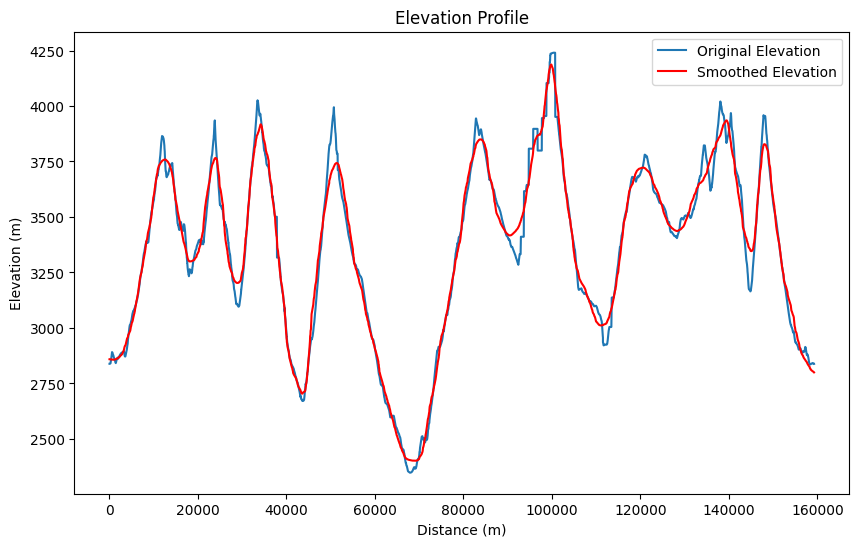

In [86]:
# Extract distance and elevation
distances = [point['distance'] for point in parsed_gpx]
elevations = [point['elevation'] for point in parsed_gpx]

# Apply Savitzky-Golay filter
# window_length should be odd and polynomial order less than window_length
smoothed_elevations = savgol_filter(elevations, window_length=281, polyorder=2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(distances, elevations, label='Original Elevation')
plt.plot(distances, smoothed_elevations, label='Smoothed Elevation', color='red')
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.title('Elevation Profile')
plt.legend()
plt.show()


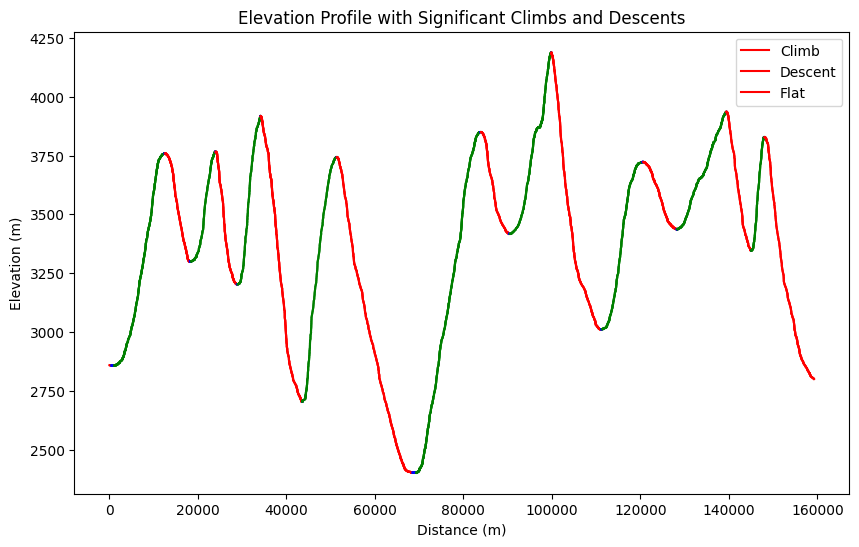

In [87]:
# Function to determine if a segment is a climb or descent
def is_significant_change(elevations, index, threshold_slope=0.1, window=15):
    # Look at the window of points around the current index
    start_index = max(0, index - window)
    end_index = min(len(elevations), index + window + 1)
    
    # Calculate the average slope over the window
    avg_slope = (elevations[end_index - 1] - elevations[start_index]) / (end_index - start_index)
    
    if avg_slope > threshold_slope:
        return 'climb'
    elif avg_slope < -threshold_slope:
        return 'descent'
    else:
        return 'flat'

# Apply the plotting
plt.figure(figsize=(10, 6))

for i in range(len(distances) - 1):
    segment_type = is_significant_change(smoothed_elevations, i)
    color = 'green' if segment_type == 'climb' else 'red' if segment_type == 'descent' else 'blue'
    plt.plot(distances[i:i + 2], smoothed_elevations[i:i + 2], color=color)

# Add legend and labels
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.title('Elevation Profile with Significant Climbs and Descents')
plt.legend(['Climb', 'Descent', 'Flat'], loc='best')

plt.show()

In [94]:
# Initialize a list to store segment data
segments = []

# Variables to track the current segment
current_segment_type = None
segment_start_index = 0
segment_start_distance = distances[0]

for i in range(1, len(distances)):
    segment_type = is_significant_change(smoothed_elevations, i)

    # Check if segment type has changed
    if segment_type != current_segment_type and current_segment_type is not None:
        segment_end_distance = distances[i - 1]
        segment_elevation_change = smoothed_elevations[i - 1] - smoothed_elevations[segment_start_index]

        # Store the previous segment data
        segment = {
            'type': current_segment_type,
            'start_distance': segment_start_distance,
            'end_distance': segment_end_distance,
            'distance': segment_end_distance - segment_start_distance,
            'elevation_change': segment_elevation_change if current_segment_type == 'climb' else -segment_elevation_change
        }
        segments.append(segment)

        # Update the current segment start
        segment_start_index = i - 1
        segment_start_distance = distances[i - 1]

    current_segment_type = segment_type

# Add the last segment if the loop ends mid-segment
if current_segment_type:
    segment_end_distance = distances[-1]
    segment_elevation_change = smoothed_elevations[-1] - smoothed_elevations[segment_start_index]
    segment = {
        'type': current_segment_type,
        'start_distance': segment_start_distance,
        'end_distance': segment_end_distance,
        'distance': segment_end_distance - segment_start_distance,
        'elevation_change': segment_elevation_change if current_segment_type == 'climb' else -segment_elevation_change
    }
    segments.append(segment)

# Now segments list is populated with objects containing the type, start and end distances, and elevation gain/loss
for segment in segments:
    print(segment)


{'type': 'descent', 'start_distance': 42.087342546686216, 'end_distance': 456.40857235290065, 'distance': 414.32122980621443, 'elevation_change': 1.0270574346354806}
{'type': 'flat', 'start_distance': 456.40857235290065, 'end_distance': 1082.1762319660866, 'distance': 625.767659613186, 'elevation_change': 0.8034260755744072}
{'type': 'climb', 'start_distance': 1082.1762319660866, 'end_distance': 12442.718477135026, 'distance': 11360.54224516894, 'elevation_change': 901.6394713798454}
{'type': 'flat', 'start_distance': 12442.718477135026, 'end_distance': 12608.88077305343, 'distance': 166.1622959184042, 'elevation_change': -0.31407233100435406}
{'type': 'descent', 'start_distance': 12608.88077305343, 'end_distance': 18162.95375791442, 'distance': 5554.07298486099, 'elevation_change': 459.4577494982427}
{'type': 'flat', 'start_distance': 18162.95375791442, 'end_distance': 18450.0778290705, 'distance': 287.12407115607857, 'elevation_change': -0.27844863168820666}
{'type': 'climb', 'start_